## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Implementations
#### Configurations

In [2]:
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'

# Training and testing ratio.
TEST_SIZE_PCT = 0.1

# Hyper-parameters tuning.
# Setting thresholds for 2 eyes' blinking rates.
THRES_BLINKING_RATE = 0.50 # The default value.
# The random forest layers.
RF_DEPTH = 10

#### Read data

In [3]:
# Read data and make them into processable formalities.
# filepath = '../Data/Results/21-11-13-13/results.csv' # Without ipa and lhipa features.
# filepath = '../Data/Results/22-11-22-23/results.csv' # With ipa and lhipa features. Sliding window: 5:3.
filepath = '../Data/Results/23-11-09-08/results.csv' # With ipa and lhipa features. Sliding window: 5:4.
filepath = '../Data/Results/23-11-09-51/results.csv' # With ipa and lhipa features. Sliding window: 2:1.6
df_raw_features = pd.read_csv(filepath)

In [4]:
df_raw_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,91.111271,89.984474,89.460969,90.480153,90.428100,90.335614,90.534758,90.501253,90.304912,90.299277,...,0.5,0.0,0.0,46.536295,-3.134211,0.391667,0.416667,lowlux,7,nothing
1,90.001346,90.399482,90.024758,90.041923,89.883373,90.632586,90.501353,89.403856,89.258905,89.723725,...,1.0,0.0,0.0,46.464442,-3.002812,0.554167,0.616667,lowlux,7,nothing
2,89.101395,89.986848,89.972960,89.132203,89.260129,90.112242,90.202167,89.894185,90.003204,90.406260,...,1.0,0.0,0.0,46.328154,-2.932342,0.754167,0.816667,lowlux,7,nothing
3,89.555615,90.007214,89.860659,89.922094,89.877920,89.865601,89.844933,89.825709,89.806331,89.786961,...,1.0,0.0,0.0,46.147413,-2.819827,0.791667,0.908333,lowlux,7,nothing
4,89.441335,89.764259,89.649271,89.683013,89.647568,89.633587,89.609090,89.603408,89.551458,89.527210,...,1.0,0.0,0.0,46.058837,-2.784676,0.591667,0.708333,lowlux,7,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14312,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,0.0,45.815622,1.618108,1.000000,0.316667,lowlux,2,THREEBACK
14313,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.794946,1.659460,1.000000,0.116667,lowlux,2,THREEBACK
14314,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.800373,1.648605,1.000000,0.091667,lowlux,2,THREEBACK
14315,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.794466,1.660419,1.000000,0.291667,lowlux,2,THREEBACK


#### Encoder

This part encodes features into numeric values.

In [5]:
# Encoding and Labeling
luxes = []
nbacks = []
df_numeric_features = df_raw_features.copy()

for index, row in df_numeric_features.iterrows():
    # Label luxes
    if LOWLUX in row[LUX]:
        luxes.append(1)
    elif MIDLUX in row[LUX]:
        luxes.append(2)
    elif HIGHLUX in row[LUX]:
        luxes.append(3)
    
    # Label task difficulties
    if NOBACK in row[LABELS]:
        nbacks.append(0)
    elif ONEBACK in row[LABELS]:
        nbacks.append(1)
    elif TWOBACK in row[LABELS]:
        nbacks.append(2)
    elif THREEBACK in row[LABELS]:
        nbacks.append(3)
        
df_numeric_features[LUX] = luxes
df_numeric_features[LABELS] = nbacks

In [6]:
df_numeric_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,91.111271,89.984474,89.460969,90.480153,90.428100,90.335614,90.534758,90.501253,90.304912,90.299277,...,0.5,0.0,0.0,46.536295,-3.134211,0.391667,0.416667,1,7,0
1,90.001346,90.399482,90.024758,90.041923,89.883373,90.632586,90.501353,89.403856,89.258905,89.723725,...,1.0,0.0,0.0,46.464442,-3.002812,0.554167,0.616667,1,7,0
2,89.101395,89.986848,89.972960,89.132203,89.260129,90.112242,90.202167,89.894185,90.003204,90.406260,...,1.0,0.0,0.0,46.328154,-2.932342,0.754167,0.816667,1,7,0
3,89.555615,90.007214,89.860659,89.922094,89.877920,89.865601,89.844933,89.825709,89.806331,89.786961,...,1.0,0.0,0.0,46.147413,-2.819827,0.791667,0.908333,1,7,0
4,89.441335,89.764259,89.649271,89.683013,89.647568,89.633587,89.609090,89.603408,89.551458,89.527210,...,1.0,0.0,0.0,46.058837,-2.784676,0.591667,0.708333,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14312,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,0.0,45.815622,1.618108,1.000000,0.316667,1,2,3
14313,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.794946,1.659460,1.000000,0.116667,1,2,3
14314,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.800373,1.648605,1.000000,0.091667,1,2,3
14315,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,1.0,0.0,0.0,45.794466,1.660419,1.000000,0.291667,1,2,3


#### Data visualization

In [7]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Auxiliary functions

In [8]:
# Show machine learning models' performance.
def show_performance(y_true, y_pred, model_name):
    # Get the accuracy score.
    score = accuracy_score(y_true, y_pred)
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    # Plot the confusion matrix.
#     ax = plt.figure().subplots()
#     ax.set(title=model_name + " MODEL")
    
#     cm_display.plot(ax=ax)
#     plt.show()
    
    return score

In [9]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
#     ax = pd.Series(df[class_column]).value_counts().sort_index().plot(kind='bar')
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

#### Clean the instances and features

In [10]:
# Select validated rows/instances by thresholdings.
def validate_instances(df_input):
    df = df_input.copy()
    
    # Plot the original class distributions.
    plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= THRES_BLINKING_RATE]
    df = df.loc[df[ISBLINK_RIGHT] <= THRES_BLINKING_RATE]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(THRES_BLINKING_RATE) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # Reset the index.
    df = df.reset_index()
    df = df.loc[:, df.columns != 'index']
    
    # Get the output.
    df_output = df.copy()
    return df_output

In [11]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
#         selected_feature_sets.append(LUX)
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets]
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

#### Run the models

In [12]:
# Run the models, get the results.
def ml_pipeline(df_input, label_string):
    df = df_input.copy()
    
    # Split dataset.
    # Get the X and y sets.
    X = df.loc[:, df.columns != LABELS].to_numpy()
    y = df.loc[:, df.columns == LABELS].to_numpy()
    y = np.reshape(y, -1)
    
    # Split the data into training dataset and validation dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PCT, random_state=999)
    
    # Train with models.
    print('------------------------------------------------' + label_string + ' Model ------------------------------------------------')
    # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
    clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
    # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
    clf_svm.fit(X_train, y_train)
    y_pred_svm = clf_svm.predict(X_test)
    score_svm = show_performance(y_true=y_test, y_pred=y_pred_svm, model_name = SVM)
    
    # KNN model.
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    # Train the model.
    clf_knn.fit(X_train, y_train)
    # Test.
    y_pred_knn = clf_knn.predict(X_test)
    score_knn = show_performance(y_true=y_test, y_pred=y_pred_knn, model_name = KNN)
    
    # Random Forest model.
    clf_rf = RandomForestClassifier(max_depth=RF_DEPTH, random_state=0)
    # Train the model.
    clf_rf.fit(X_train, y_train)
    # Test.
    y_pred_rf = clf_rf.predict(X_test)
    score_rf = show_performance(y_true=y_test, y_pred=y_pred_rf, model_name = RF)
    
    # Print the results.
    print('\nThe SVM result is: ' + str(score_svm) +  '\nThe KNN result is: ' + str(score_knn) +  '\nThe RF result is: ' + str(score_rf))
    print('\nThe used features are: ') # Briefly display the features utilized.
    print(df)
    
    # Output the data.
    df_output = df.copy()
    return df_output

#### Machine Learning Implementations

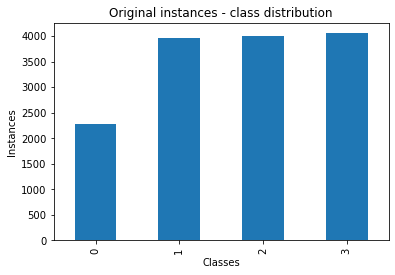

The blinking threshold is: 0.5. Before there was: 14317 instances, then there is : 8239 instances. 6078 instances are lost.


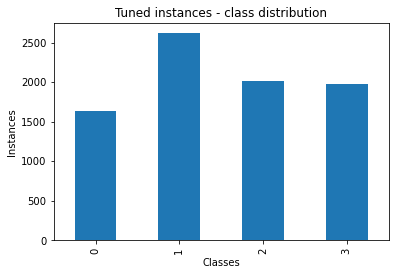

------------------------------------------------Time-domain-based Features Model ------------------------------------------------

The SVM result is: 0.4016990291262136
The KNN result is: 0.5752427184466019
The RF result is: 0.5934466019417476

The used features are: 
      Averaged Diameter  Difference Diameter  Labels
0             46.536295            -3.134211       0
1             45.915047            -2.923337       0
2             45.938325            -2.962663       0
3             46.011382            -2.962952       0
4             46.056491            -2.985568       0
...                 ...                  ...     ...
8234          45.425522             1.442357       3
8235          46.134607             1.792140       3
8236          45.978092             1.943484       3
8237          45.895944             1.913502       3
8238          45.773865             1.963937       3

[8239 rows x 3 columns]
------------------------------------------------Freq-domain-based IPA 

In [ ]:
# The pipeline for experiments.

# Get validated instances.
df_all_features = validate_instances(df_input=df_numeric_features)

# Looping and fine-tuning hyper-parameters. <TODO>

# Compare different features.
# Time-domain baseline feature sets.
time_domain_features = [AVE_DM, DIFF_DM]
df_baseline_time_features = select_features(df_input=df_all_features, selected_feature_sets=time_domain_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_time_features, label_string='Time-domain-based Features')

# Freqeuncy baseline feature sets.
freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]
df_baseline_freq_features_ipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_ipa_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_freq_features_ipa, label_string='Freq-domain-based IPA Features')

freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
df_baseline_freq_features_lhipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_lhipa_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baseline_freq_features_lhipa, label_string='Freq-domain-based LHIPA Features')

# Only wavelet coefficients features.
dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)
ml_pipeline(df_input=df_only_coefs, label_string='Only Wavelet Coefficients Features')

# IPA LHIPA and AVE_DM + DF_DM features.
freq_time_baseline_features = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_baselines = select_features(df_input=df_all_features, selected_feature_sets=freq_time_baseline_features, dropped_feature_sets=False)
ml_pipeline(df_input=df_baselines, label_string='All Time and Frequency Domain Baseline Features')

# My proposed feature based features.
dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_proposed = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_features)
ml_pipeline(df_input=df_proposed, label_string='My Proposed Features')

# All features baseline.
df_all_baseline = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=False)
ml_pipeline(df_input=df_all_baseline, label_string='All Features')

## TODO list

In [ ]:
# <TODO: get an arguments stuff>
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--path", type=str, default='/content/gdrive/MyDrive/CS5242/project', 
#                         help="path")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--times', type=int, default=1,
#                         help='loop times of the whole process')
#     parser.add_argument('--sequence_len', type=int, default=1,
#                         help='20/1')
#     parser.add_argument('--train', type=bool, default=True,
#                         help='')
#     parser.add_argument('--predict', type=bool, default=True,
#                         help='')
#     parser.add_argument('--debug_mode', type=bool, default=False,
#                         help='adjust parameters ?')
#     # parser.add_argument('--model', type=str, default='bert',
#     #                     help='support bert/bert_lstm/bert_cnn/word2vec')
#     parser.add_argument('--model', type=str, default='MLP', choices=['bert', 'bert_lstm', 'bert_cnn', 'word2vec', 'MLP'], help='support bert/bert_lstm/bert_cnn/word2vec/MLP')
    
#     parser.add_argument('--language', type=str, default='en',
#                         help='support en')
#     parser.add_argument('--early_stop', type=int, default=60,
#                         help='')
#     parser.add_argument('--features_dim', type=int, default=768,# ?
#                         help='')
#     parser.add_argument('--batch_size', type=int, default=16,
#                         help='')
#     parser.add_argument('--train_rate', type=float, default=0.6,
#                         help='')
#     parser.add_argument('--test_rate', type=float, default=0.2,
#                         help='')
#     parser.add_argument('--num_workers', type=int, default=0,
#                         help='num workers of loading data')
    
#     parser.add_argument('--label', type=str, default='activation',
#                         help='support activation/polarity')
#     parser.add_argument('--num_classes', type=int, default=3,
#                         help='class number')
    
#     parser.add_argument('--train_size', type=str, default='normal',
#                         help='normal')
#     parser.add_argument('--model_save_path', type=str, default='model_save',
#                         help='path to save model.')
#     parser.add_argument('--data_dir', type=str, default='/word2vec.pkl',
#                         help='path to data directory word2vec.pkl/bert_feature.pkl')
#     parser.add_argument('--log_path', type=str, default='/content/gdrive/MyDrive/CS5242/project/log/',
#                     help='path to data directory feature.pkl')
#     return parser.parse_args(args = [])
#
#     args = parse_args()
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--max_seq_length', type=int, default = 50,
#                         help='length')
#     parser.add_argument('-f')
#     return parser.parse_args()
# 
#     save_data(args, features, '/word2vec.pkl')
# def save_data(args, features, save_path):
#     path = os.path.abspath(os.path.join(os.getcwd(), ".."))
#     with open(os.path.join(path, "data/" + save_path),'wb') as file_obj:
#         pickle.dump(features,file_obj)
#         print('Save Successful!')